In [183]:
import numpy as np
import matplotlib.pyplot as plt

import math
import openmc
import openmc.mgxs as mgxs
import openmc.data
import random
import h5py
import copy

In [184]:
class Sig:
    def __init__(self):
        self.number_groups = 0
        self.sig_f = []
        self.capture = []
        self.scattering = []
        self.total = []
        self.number_of_production_neutrons = []
        self.c_value = []
        
    def __init__(self, number_groups, sig_f, sig_c, sig_s, number_of_production_neutrons, sig_t):
        self.number_groups = number_groups
        self.sig_f = sig_f
        self.sig_c = sig_c
        self.sig_s = sig_s      
        self.number_of_production_neutrons = number_of_production_neutrons
        self.sig_t = sig_t
        self.get_virtual_cs()
               
    def get_virtual_cs(self):
        max_total_cs = max(self.sig_t)
        self.virtual = [cross_section - max_total_cs for cross_section in self.sig_t]
        
    def get_fission_probability(self, energy_group_idx):
        return self.sig_f[energy_group_idx] / self.sig_t[energy_group_idx]
    
    def get_capture_probability(self, energy_group_idx):
        return self.sig_c[energy_group_idx] / self.sig_t[energy_group_idx]
        
    def get_scatter_probability(self, energy_group_idx):
        return self.sig_s[energy_group_idx] / self.sig_t[energy_group_idx]
        

In [185]:
energy_groups_2 = [0, 2 * 1E10]

In [186]:
class Positon:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

In [187]:
class Direction:
    def __init__(self, ets, phi):
        self.tetta_x = math.sin(ets) * math.cos(phi)
        self.tetta_y = math.sin(ets) * math.sin(phi)
        self.tetta_z = math.cos(ets)

In [188]:
class Particle:
    def __init__(self):
        self.coordinates = Positon(0, 0, 0)
        self.direction = Direction(0, 0)
        self.energy = 0
        self.weight = 1
        self.energy_groups = []
        self.terminated = False
        self.path = 0. 
        
    def set_coordinates(self, x, y, z):
        self.coordinates = Positon(x, y, z)
        
    def set_direction(self, ets, phi):
        self.direction = Direction(ets, phi)
    
    def set_direction_angle(self, angle):
        self.direction = angle
        
    def set_energy_groups(self, energy_groups):
        self.energy_groups = energy_groups
        
    def get_energy_group(self):  
        res = next(x for x, val in enumerate(self.energy_groups)
                                  if val > self.energy)        
        return res - 1
    
    def set_terminated(self):
        self.terminated = True
        
    def is_terminated(self):
        return self.terminated
        
    def get_weight(self):
        return self.weight
    
    def set_weight(self, weight):
        self.weight = weight
    
    def set_particle_deleted(self):
        self.weight = self.weight * 0
        
    def set_particle_fission(self, additional_weight):
        self.weight = self.weight * additional_weight
        
    def set_multiplicity(self, additional_weight):
        self.weight = self.weight * additional_weight
              
    def is_particle_deleted(self):
        return self.weight < 0.0001
    
    def add_path(self, path):
        self.path += path
    
    def get_path(self):
        return self.path
    
    def set_path(self, path):
        self.path = path
        
    def print_direction(self):
        print(str(self.direction.tetta_x) + " " + str(self.direction.tetta_y) + " " + str(self.direction.tetta_z))
        
    def print_coordinates(self):
        print(str(self.coordinates.x) + "  " + str(self.coordinates.y) + " " + str(self.coordinates.z))  
        

In [189]:
class Plane:
    def __init__(self, A, B, C, D):
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        
    def distance(self, particle):
        vp = (self.A * particle.direction.tetta_x + self.B * particle.direction.tetta_y + 
              self.C * particle.direction.tetta_z)
        
        
        if (abs(vp) < 1e-9):
            return -1
        
        distance = (self.D - self.A * particle.coordinates.x - self.B * particle.coordinates.y 
                    - self.C * particle.coordinates.z) / vp
        
        return distance 
    
    def get_normal(self):
        sq = math.sqrt(self.A * self.A + self.B * self.B + self.C * self.C)
        a_n = self.A / sq
        b_n = self.B / sq
        c_n = self.C / sq
        return [a_n, b_n, c_n]
    

    def get_sign(self, particle):
      
        sign = (self.A * particle.coordinates.x + self.B * particle.coordinates.y +
        self.C * particle.coordinates.z - self.D)
        
        if sign == 0:
            return sign    
            
        if sign < 0:
            return -1
        else:
            return 1
        
    def get_xml(self):
        
        obj_xml = " Plane with A "+ str(self.A) + " B "+ str(self.B) + " C "+ str(self.C) + " D "+ str(self.D)
        
        return obj_xml
    

In [190]:
## Infinite cylinder parallel to z-axis

class ZCylinder:
    def __init__(self, x_0, y_0, r):
        self.x_0 = x_0
        self.y_0 = y_0
        self.r = r
        
    def distance(self, particle):
    
        a_ = particle.direction.tetta_x * particle.direction.tetta_x + (particle.direction.tetta_y * particle.direction.tetta_y )
        
        ## If a=0a 0a=0, this means the particle is parallel to the cylinder and will thus never intersect it
        if (abs(a_) < 1e-9):
            return -1
        
        c_ = ((particle.coordinates.x - self.x_0) * (particle.coordinates.x - self.x_0) + 
              (particle.coordinates.y - self.y_0) * (particle.coordinates.y - self.y_0) - self.r * self.r)

        k_ = (particle.coordinates.x -self.x_0) * particle.direction.tetta_x + (particle.coordinates.y -self.y_0) * particle.direction.tetta_y
        
        dec = k_ * k_ - a_ * c_
        
        if dec < 0:
            return -1
        
        dist_1 = (-k_ + math.sqrt(k_ * k_ - a_ * c_))/a_
        dist_2 = (-k_ - math.sqrt(k_ * k_ - a_ * c_))/a_
         
        distance = min(dist_1, dist_2)
        
        return distance 
    
    def get_normal(self):
        sq = math.sqrt(self.A * self.A + self.B * self.B + self.C * self.C)
        a_n = self.A / sq
        b_n = self.B / sq
        c_n = self.C / sq
        return [a_n, b_n, c_n]
    
    def get_reflected_direction(self, angle):
        
        eps = random.uniform(0, math.pi * 2)
        tetta = random.uniform(0, math.pi)
        r_reflected = Direction(eps, tetta)
        
        return r_reflected  
    
    def get_sign(self, particle):
            
        sign = ((self.x_0 - particle.coordinates.x) * (self.x_0 - particle.coordinates.x) + 
        (self.y_0 - particle.coordinates.y) * (self.y_0 - particle.coordinates.y) - self.r * self.r)
        
        if sign == 0:
            return 0
            
        if sign < 0:
            return -1
        else:
            return 1
        
        
    def get_xml(self):

        obj_xml = " ZCylinder with x_0 "+ str(x_0) + " y_0 "+ str(y_0) + " r = "+ str(r) 
        
        return obj_xml

In [191]:
class Cell:
    def __init__(self):
        self.surfaces = []
        self.boundaries_type = []
        self.signs = []
        self.size = 0
        
    def set_boundaries_type(self, boundaries_type):
        self.boundaries_type = boundaries_type        
        
    def set_box_sizes(self, x_size, y_size, z_size):
        self.x_size = x_size
        self.y_size = y_size
        self.z_size = z_size
        
    def set_zero_point(self, x_0, y_0, z_0):
        self.x_0 = x_0
        self.y_0 = y_0
        self.z_0 = z_0
        
    def __init__(self, surfaces, signs):
        self.surfaces = surfaces
        self.signs = signs
        self.size = len(self.signs)
           
    def is_inside(self, particle):
        
        is_inside = True
        for i in range(0, self.size):
            sign = self.surfaces[i].get_sign(particle)
            if self.signs[i] != sign:
                is_inside = False
                
        return is_inside
    
    def is_boudary_reflective(self, particle):
         for i in range(0, self.size):
            sign = self.surfaces[i].get_sign(particle)
            if self.signs[i] != sign:
             #   print("   " + str(i))
                if boundaries_type[i] == 'reflective':
                    return True
                else:
                    return False
        
    
    def get_minimum_distance(self, particle):
        
        minimum_distance = math.inf
        surface_idx = 0
        for i in range(0, len(self.surfaces)):
            current_distance = self.surfaces[i].distance(particle)
            if current_distance > 0:
                minimum_distance = min(minimum_distance, current_distance)
                surface_idx = i
        return minimum_distance, surface_idx
    
    def get_xml(self):
        
        xml_obj = []
        for i in range(0, self.size):
            xml_obj.append(surfaces[i].get_xml())
            
        return xml_obj
    
    def reflect_particle(self, particle):

        if particle.coordinates.x > (self.x_size/2. + self.x_0):
            particle.coordinates.x -= self.x_size/2.
        
        if particle.coordinates.y > (self.y_size/2. + self.y_0):
            particle.coordinates.y -= self.y_size/2.
        
        if particle.coordinates.z > (self.z_size/2. + self.z_0):
            particle.coordinates.z -= self.z_size/2.
            
        
        if particle.coordinates.x < (-self.x_size/2. + self.x_0):
            particle.coordinates.x += self.x_size/2.
        
        if particle.coordinates.y < (-self.y_size/2. + self.y_0):
            particle.coordinates.y += self.y_size/2.
        
        if particle.coordinates.z < (-self.z_size/2. + self.z_0):
            particle.coordinates.z += self.z_size/2.
              

In [192]:
class Universe:
    def __init__(self, cells, xs):
        self.cells = cells
        self.xs = xs
        
    def get_xs_by_coordinates(self, particle):
        
        for i in range(0, len(cells)):
            cell = cells[i]
            if not cell.is_inside(particle):
                return self.xs[i]
            
            

In [193]:
def set_random_direction(particle):
    r = 1.0
    r1 = 1.0
    while (r**2 + r1**2 > 1.0):
        r = 2. * random.uniform(0, 1) - 1.
        r1 = 2. * random.uniform(0, 1) - 1.
        
    direction_x = 2.0 * r**2 + 2. * r1**2 - 1.0  
    particle.direction.tetta_x = direction_x
    particle.direction.tetta_y = r * math.sqrt((1.0 - direction_x**2)/(r**2+r1**2))
    particle.direction.tetta_z = r1 * math.sqrt((1.0 - direction_x**2)/(r**2+r1**2))

In [195]:
class Flux_estimator:
    def __init__(self, universe):
        self.boundaries = universe
        self.collision_sum = [0]
        
    def add_collision(self, particle):
        if self.boundaries.is_inside(particle):
            self.collision_sum[-1]  += particle.get_weight()
            
        

In [196]:
import random

def make_initial_sources(number_of_paricles, box_size, energy=10.0e6):
    
    step_x = 2 * box_size[0]/number_of_paricles
    step_y = 2 * box_size[1]/number_of_paricles
    step_z = 2 * box_size[2]/number_of_paricles
    
    x_coord = -box_size[0]
    y_coord = -box_size[1]
    z_coord = -box_size[2]
    
    sources = []
    for i in range(0, number_of_paricles):
        for j in range(0, number_of_paricles):
            for k in range(0, number_of_paricles):
                current_particle = Particle()
                current_particle.set_coordinates(x_coord + k * step_x, y_coord + j * step_y, z_coord+ i * step_z)
                set_random_direction(current_particle)
                current_particle.energy = energy
                current_particle.set_energy_groups(energy_groups_2)
                sources.append(current_particle)

    return sources

In [197]:
def get_free_path(particle, c_s):
    
    energy_group_idx = particle.get_energy_group()   
    sig_t = c_s.sig_t[energy_group_idx]
    free_path = -math.log(random.uniform(0, 1)) / sig_t
    
    return free_path  

In [198]:
def move_particle(particle, t):
    new_x = particle.direction.tetta_x * t + particle.coordinates.x
    new_y = particle.direction.tetta_y * t + particle.coordinates.y
    new_z = particle.direction.tetta_z * t + particle.coordinates.z
    particle.set_coordinates(new_x, new_y, new_z)

In [199]:
def is_collision_virual(particle, c_s):
    
    energy_group_idx = particle.get_energy_group()
    random_number = random.uniform(0, 1)
    virtual_cs = c_s.virtual[energy_group_idx]
    total_cs = c_s.sig_t[energy_group_idx]
    if virtual_cs / total_cs >= random_number:
        return True
    else:
        return False

In [200]:
def process_virtual_collision(particle, free_path):
    particle.add_path(free_path)

In [201]:
def process_real_collision(particle, free_path, c_s):
    
    energy_group_idx = particle.get_energy_group()
    weight_before_collision = particle.get_weight()
    number_of_production_neutrons = c_s.number_of_production_neutrons[energy_group_idx]   
    capture_probability = c_s.get_capture_probability(energy_group_idx)
    scatter_probability = c_s.get_scatter_probability(energy_group_idx)  
    fission_probability = c_s.get_fission_probability(energy_group_idx)  
    
    
    type_collision = np.random.choice(['capture', 'scatter', 'fission'], p=[capture_probability, scatter_probability,
                                                                            fission_probability])
    if type_collision == 'capture':
        particle.set_terminated()
        particle.set_weight(0.)
        
    if type_collision == 'scatter':      
        set_random_direction(particle)
        
    if type_collision == 'fission':    
        particle.set_particle_fission(number_of_production_neutrons)
        particle.set_terminated()
        
    return weight_before_collision
        

In [202]:
def delete_absorpbed_paricles(particles):
    
    existing_particles = []
    for i in range(0, len(particles)):
        particle = particles[i]
        if particle.get_weight() > 0.000001:
            existing_particles.append(particle)
                     
    return existing_particles

In [203]:
def process_one_particle_history(particle, universe, c_s, estimators):
    
    sum_collisions = 0.
    while not particle.is_terminated():
        free_path = get_free_path(particle, c_s)
        set_random_direction(particle)
        move_particle(particle, free_path)
        if not universe.is_inside(particle):
            if universe.is_boudary_reflective(particle):
                universe.reflect_particle(particle)

            else:
                particle.set_terminated()
                particle.set_weight(0.)
                
        for k in estimators:
            k.add_collision(particle)
            
        if is_collision_virual(particle, c_s):
            process_virtual_collision(particle, free_path)
        else:
            process_real_collision(particle, free_path, c_s)
        
            
    return particle, sum_collisions

In [204]:
def get_weights(particles):
    
    weights = []
    for i in range(0, len(particles)):
        weights.append(particles[i].weight)
        
    return weights

In [205]:
def make_sources(particles):
    for i in range(0, len(particles)):
        particles[i].terminated = False

In [206]:
def splitting_secound_version(particles):
    
    initial_size = len(particles)
    
    for i in range(0, initial_size):
        particle = particles[i]
        current_weight = particle.get_weight()
        if current_weight > 1:
            n_value = math.floor(current_weight)
            random_value = random.uniform(0, 1)
            if current_weight - n_value >= random_value:
                n_value += 1
            if n_value > 1:
                particle.set_weight(current_weight / n_value)
                for j in range(0, n_value - 1):
                    particles.append(copy.deepcopy(particle))
                    

In [207]:
def splitting_without_random(particles):
     
    initial_size = len(particles)
    
    for i in range(0, initial_size):
        particle = particles[i]
        current_weight = particle.get_weight()
        if current_weight > 1:
            n_value = math.floor(current_weight)          
            particle.set_weight(current_weight / n_value)
            for j in range(0, n_value - 2):
                particles.append(copy.deepcopy(particle))
            additonal_particle = copy.deepcopy(particle)
            additonal_particle.set_weight(current_weight - n_value)
            particles.append(additonal_particle)

In [208]:
def normalise_weights(particles, batch_size):

    sum_weights = 0.
    
    for i in range(0, len(particles)):
        sum_weights += particles[i].get_weight()

    for i in range(0, len(particles)):
        particles[i].weight = (particles[i].weight * batch_size) / sum_weights   
        
    return particles

In [209]:
def russian_roulette(weights_previous, particles_current):
    
    for i in range(0, len(particles_current)):
        particle = particles_current[i]
        if particle.weight > 0 and particle.weight < 0.5 and particle.weight < weights_previous[i]:
            probability_terminate = 1. - particle.weight / weights_previous[i]
            random_number = random.uniform(0, 1)
            if probability_terminate >= random_number:
                particle.set_weight(0.)
            else:
                particle.set_weight(weights_previous[i])


In [210]:
def flux_estimator(cell_volume, start_weight, particles_current_iteration, cross_section):
    
    sum_weighted_paths = 0.
    
    for i in range(0, len(particles_current_iteration)):
        particle = particles_current_iteration[i]
        energy_group_idx = particle.get_energy_group() 
  
        number_of_production_neutrons = cross_section.number_of_production_neutrons[energy_group_idx]   
        sum_weighted_paths += particles_current_iteration[i].get_weight()* (
            particles_current_iteration[i].get_path())
        
    total_flux = sum_weighted_paths/(cell_volume * start_weight)
    
    return total_flux
    

In [211]:
def terminate_outside_particles(batch_particles, universe):
    
    for j in range(0, len(batch_particles)):
        particle = batch_particles[j]
        if not universe.is_inside(particle):
            print("ERROR! outside particle")

In [212]:
def reset_estimators(estimators, weight_previos, volume, sum_collisions, c_s):
    
    sig_t = c_s.sig_t[0]

    for estimator in estimators:
        estimator.collision_sum[-1] = estimator.collision_sum[-1] / ( sum(weight_previos)  * sig_t)
        estimator.collision_sum.append(0.)    

In [213]:
def calculate_k_effective(idx, weights, number_interations, number_inactive, initial_size, k_effective,
                         k_effective_exp, std_k_effective):
    
    keff_cycle = sum(weights) / initial_size
    if idx > number_inactive:
        k_effective.append(keff_cycle)
    
        k_effective_exp.append(sum(k_effective) / len(k_effective))

        
        std_current = 0.
        
        for i in range(0, idx - number_inactive):
            std_current += (k_effective[i] - k_effective_exp[idx - number_inactive - 1])**2
            
        std_k_effective.append(math.sqrt(std_current)/(idx * max(idx - 1, 1)))

        print(" keff_cycle , k_effective_exp, std_k_effective " + str(keff_cycle) + "   " + str(k_effective_exp[-1]) +
                                    "  "+ str(std_k_effective[-1]))
            

In [215]:
import statistics
import time


def simulation_black_boundaries(universe, number_interations, number_inactive, number_of_particles, c_s, estimators,
                                volume=1):
    
    random.seed(time.time())
    k_effective = []
    k_effective_std = []
    k_effective_exp = []
    flux = []
    flux_exp = []
    num1 = random.randint(0,9)
    
    print(" num1  " + str(num1))
    
    initial_sources = make_initial_sources(number_of_particles, energy=10.0e6, box_size=[0.5, 0.5, 0.5])
    initial_size = len(initial_sources)
    
    weights_previous = [1.] * len(initial_sources)
    
    for i in range(0, number_interations):
        print("i == " + str(i))
        
        make_sources(initial_sources)
        batch_size = len(initial_sources)
        
        batch_particles = []
        total_collisions = 0.

        for j in range(0, batch_size):
            
            particle = initial_sources[j]
            terminate_particle, sum_collisions = process_one_particle_history(particle, universe, c_s, estimators)
            batch_particles.append(terminate_particle)
            total_collisions += sum_collisions
        
        russian_roulette(weights_previous, batch_particles)
        
        batch_particles = delete_absorpbed_paricles(batch_particles)
        
        splitting_secound_version(batch_particles)
        
        weights_cycle = get_weights(batch_particles)
        
        calculate_k_effective(i, weights_cycle, number_interations, number_inactive, initial_size, k_effective,
                         k_effective_exp, k_effective_std)
        
        flux.append(calculate_flux(weights_previous, volume, total_collisions, c_s))
        
        reset_estimators(estimators, weights_previous, volume, sum_collisions, c_s) 
        

        batch_particles = normalise_weights(batch_particles, initial_size) 
        

        initial_sources = batch_particles
        weights_previous = get_weights(batch_particles)

            
    return k_effective, k_effective_exp, k_effective_std, estimators

In [216]:
def save_simulation_results_to_file(number_of_particles, number_interations, number_inactive,
                                   universe, k_effective, k_effective_exp, k_effective_std, file_name):
    
    f = open(file_name, "w")
    f.write("number of particles  " + str(number_of_particles) + "\n")
    f.write("number of interations  " + str(number_interations) + "\n")
    f.write("number inactive  " + str(number_inactive) + "\n")
    universe_discription = universe.get_xml()
    f.write("geometry \n")
    for xml_cell in universe_discription:
        f.write(xml_cell + "\n")
    
    for i in range(0, len(k_effective)):
        f.write(" cycle k effective "+ str(k_effective[i]) + "  average k effective "+ str(k_effective_exp[i]) + "  std "+ 
                str(k_effective_std[i]) + '\n')
            
    
    f.close()

In [217]:
cs_fission_pu_239 = [0.081600]

cs_fission_h2o = [0.0]

cs_capture_pu_239 = [0.019584]

cs_capture_h2o = [0.032640]

cs_scattering_pu_239 = [0.225216]

cs_scattering_h2o = [0.293760]

cs_total_pu_23 = [0.32640]

cs_total_h2o = [0.32640]

cs_production_neutrons_pu_239 = [2.84]

cs_production_neutrons_h2o = [0.0]

pu_23_cs_1_4 = Sig(1, cs_fission_pu_239, cs_capture_pu_239, cs_scattering_pu_239, 
                       cs_production_neutrons_pu_239,  cs_total_pu_23)

h2o_cs_1_4 = Sig(1, cs_fission_h2o, cs_capture_h2o, cs_scattering_h2o, cs_production_neutrons_h2o,
                cs_total_h2o)



energy_groups_2 = [0, 2 * 1E10]

In [233]:
def compute_std(keff_cycle_exp):
    
    sample_std = []
    for i in range(2, len(keff_cycle_exp)):
        sample_std.append(np.std(keff_cycle_exp[:i]))
        
    return sample_std

In [244]:
def get_quarter_slab_estimators(radius):
    
    estimators = []
    
    points_to_divide = [0., 0.25, 0.5, 0.75, 1]
    epsilon = 0.2
    
    for point in points_to_divide:
        
        x_5 = Plane(1, 0, 0, 100)
        x_m5 = Plane(1, 0, 0, -100)
        
        if point < 1:
            y_5 = Plane(0, 1, 0, point * radius + epsilon)
            
        else:
            y_5 = Plane(0, 1, 0, point * radius)
            
        y_m5 = Plane(0, 1, 0, point * radius - epsilon)


        z_5 = Plane(0, 0, 1, 100)
        z_m5 = Plane(0, 0, 1, -100)

        surfaces = [x_5, x_m5, y_5, y_m5, z_5, z_m5]

        signs = [-1, +1, -1, +1, -1, +1]
        current_slub = Cell(surfaces, signs)
        
        estimators.append(Flux_estimator(current_slub))
        
    return estimators

    

In [246]:
x_5 = Plane(1, 0, 0, 100)
x_m5 = Plane(1, 0, 0, -100)

y_5 = Plane(0, 1, 0, 2.256751)
y_m5 = Plane(0, 1, 0, -2.256751)


z_5 = Plane(0, 0, 1, 100)
z_m5 = Plane(0, 0, 1, -100)

surfaces = [x_5, x_m5, y_5, y_m5, z_5, z_m5]

signs = [-1, +1, -1, +1, -1, +1]
slab_2 = Cell(surfaces, signs)

boundaries_type = [ "reflective", "reflective", "black", "black", "reflective", "reflective"]

slab = Cell(surfaces, signs)

slab.set_boundaries_type(boundaries_type)

slab.set_box_sizes(100., 0., 100.)
slab.set_zero_point(0., 0., 0.)

In [247]:
estimators_slab = get_quarter_slab_estimators(2.256751)  

In [248]:
test_number_of_particles = 20
test_number_interations = 50
test_number_inactive = 50

In [249]:
k_effective, k_effective_exp, k_effective_std, estimators = simulation_black_boundaries(slab,  test_number_interations,  test_number_inactive, 
                           test_number_of_particles, pu_23_cs_1_4, estimators_slab)

 num1  1
i == 0
i == 1
i == 2
i == 3
i == 4
i == 5
i == 6
i == 7
i == 8
i == 9
i == 10
i == 11
i == 12
i == 13
i == 14
i == 15
i == 16
i == 17
i == 18
i == 19
i == 20
i == 21
i == 22
i == 23
i == 24
i == 25
i == 26
i == 27
i == 28
i == 29
i == 30
i == 31
i == 32
i == 33
i == 34
i == 35
i == 36
i == 37
i == 38
i == 39
i == 40
i == 41
i == 42
i == 43
i == 44
i == 45
i == 46
i == 47
i == 48
i == 49


In [240]:
difference = (k_effective_exp[-1] - 1.0) * 100000
std_1 = compute_std(k_effective_exp)
standart_deviation = std_1[-1] * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))


IndexError: list index out of range

In [243]:
average_number_of_collision = []
for i in range(0, len(estimators_slab)):
    estimator = estimators_slab[i]
    average_number_of_collision.append((sum(estimator.collision_sum)) / len(estimator.collision_sum))
    
    zero_point = average_number_of_collision[0]
for i in range(0, len(average_number_of_collision)):
    average_number_of_collision[i] = average_number_of_collision[i]/ zero_point
    
print(average_number_of_collision)   

[1.0, 0.2187768409756248, 0.1953291348826682, 0.162667859721822, 0.05926573161285822]


In [250]:
def get_normalise_flux(estimators):
    
    average_number_of_collision = []
    for i in range(0, len(estimators)):
        current_estimator = estimators[i]
        average_number_of_collision.append((sum(current_estimator.collision_sum)) / len(current_estimator.collision_sum))        
    
    zero_point = average_number_of_collision[0]
    
    result_flux = []
    for i in range(1, len(average_number_of_collision)):
        result_flux.append(average_number_of_collision[i] / zero_point)
        
    result_flux[-1] = result_flux[-1] * 2.
        
    
        
    return result_flux

In [251]:
number_collision = get_normalise_flux(estimators)

In [ ]:
slab_flux_estimator = [0.9701734, 0.8810540, 0.7318131, 0.4902592]

In [ ]:
for i in range(0, len(flux_slub)):
    print((flux_slub[i] - number_collision[i])/flux_slub[i] * 100) 

In [228]:
slab_flux_estimator = [0.9701734, 0.8810540, 0.7318131, 0.4902592]

In [229]:
difference = []

for i in range(0, len(slab_flux_estimator)):
    difference = (slab_flux_estimator[i] - average_number_of_collision[i])/ slab_flux_estimator[i] * 100

In [286]:
def get_quarter_cylinder_estimators(radius):
    
    estimators = []
    
    points_to_divide = [0.5, 1]
    epsilon = 0.2
    
    
    cylinder_2 = ZCylinder(0, 0, epsilon)
    plane_5 = Plane(0, 0, 1, 1000)
    plane_6 = Plane(0, 0, 1, -1000)

    surfaces = [cylinder_2, plane_5, plane_6]
    signs = [-1, -1, +1]

    cylinder = Cell(surfaces, signs)
    estimators.append(Flux_estimator(cylinder))
    
    for point in points_to_divide:
        
        if point < 1:
            cylinder_1 = ZCylinder(0, 0, point * radius + epsilon)        
        else:
            cylinder_1 = ZCylinder(0, 0, point * radius)
            
        cylinder_2 = ZCylinder(0, 0, point * radius - epsilon)
        

        plane_5 = Plane(0, 0, 1, 1000)
        plane_6 = Plane(0, 0, 1, -1000)

        surfaces = [cylinder_1, cylinder_2, plane_5, plane_6]
        signs = [-1, +1, -1, +1]

        cylinder = Cell(surfaces, signs)
        estimators.append(Flux_estimator(cylinder))        
        
        
    return estimators

In [287]:
test_number_of_particles = 20
test_number_interations = 1500
test_number_inactive = 50

In [288]:
cylinder_estimators = get_quarter_cylinder_estimators(4.279960)

In [289]:
first_estimator = cylinder_estimators[0]

first_estimator

In [302]:
test_cylinder = ZCylinder(0, 0, 4.279960)

plane_5 = Plane(0, 0, 1, 1000)
plane_6 = Plane(0, 0, 1, -1000)

surfaces = [test_cylinder, plane_5, plane_6]
signs = [-1, -1, +1]
boundaries_type = ["black", "reflective", "reflective"]

cylinder = Cell(surfaces, signs)

cylinder.set_boundaries_type(boundaries_type)

cylinder.set_box_sizes(0., 0., 10.)
cylinder.set_zero_point(0., 0., 0.)


In [303]:
test_number_of_particles = 30
test_number_interations = 1000
test_number_inactive = 50

In [304]:

k_effective, k_effective_exp, k_effective_std, estimators = simulation_black_boundaries(cylinder,  test_number_interations,  test_number_inactive, 
                           test_number_of_particles, pu_23_cs_1_4, cylinder_estimators)

 num1  1
i == 0
i == 1
i == 2
i == 3
i == 4
i == 5
i == 6
i == 7
i == 8
i == 9
i == 10
i == 11
i == 12
i == 13
i == 14
i == 15
i == 16
i == 17
i == 18
i == 19
i == 20
i == 21
i == 22
i == 23
i == 24
i == 25
i == 26
i == 27
i == 28
i == 29
i == 30
i == 31
i == 32
i == 33
i == 34
i == 35
i == 36
i == 37
i == 38
i == 39
i == 40
i == 41
i == 42
i == 43
i == 44
i == 45
i == 46
i == 47
i == 48
i == 49
i == 50
i == 51
 keff_cycle , k_effective_exp, std_k_effective 0.9989973546702325   0.9989973546702325  0.0
i == 52
 keff_cycle , k_effective_exp, std_k_effective 1.0065104961076137   1.002753925388923  2.0032402935089907e-06
i == 53
 keff_cycle , k_effective_exp, std_k_effective 1.0047801067026716   1.0034293191601726  2.018949165364951e-06
i == 54
 keff_cycle , k_effective_exp, std_k_effective 1.0044545637828768   1.0036856303158488  1.968769779688588e-06
i == 55
 keff_cycle , k_effective_exp, std_k_effective 0.9944312313991255   1.001834750532504  3.371445755519054e-06
i == 56
 keff_cycle , 

 keff_cycle , k_effective_exp, std_k_effective 1.0021792309148758   1.0008901035917193  4.482985774219434e-06
i == 119
 keff_cycle , k_effective_exp, std_k_effective 1.003438599789874   1.0009270383192288  4.411322360948439e-06
i == 120
 keff_cycle , k_effective_exp, std_k_effective 0.9964619813279192   1.0008632517907816  4.348894472939308e-06
i == 121
 keff_cycle , k_effective_exp, std_k_effective 0.990287093744734   1.000714291818302  4.337730280298658e-06
i == 122
 keff_cycle , k_effective_exp, std_k_effective 1.0070016297883826   1.0008016159567754  4.287531781372334e-06
i == 123
 keff_cycle , k_effective_exp, std_k_effective 1.0031272787091525   1.0008334743506435  4.220623261480999e-06
i == 124
 keff_cycle , k_effective_exp, std_k_effective 1.015854961666524   1.0010364674224796  4.266210699752746e-06
i == 125
 keff_cycle , k_effective_exp, std_k_effective 1.0035070316553043   1.0010694082789173  4.200935869979621e-06
i == 126
 keff_cycle , k_effective_exp, std_k_effective 1.001

 keff_cycle , k_effective_exp, std_k_effective 0.9913628849652195   1.0005530050934799  2.4847054281891737e-06
i == 188
 keff_cycle , k_effective_exp, std_k_effective 0.9956367100254839   1.0005173797669003  2.4622179645598454e-06
i == 189
 keff_cycle , k_effective_exp, std_k_effective 1.0062600513398121   1.000558693950878  2.4414794583187974e-06
i == 190
 keff_cycle , k_effective_exp, std_k_effective 1.0153128645126206   1.0006640808834617  2.450223640656531e-06
i == 191
 keff_cycle , k_effective_exp, std_k_effective 0.997222415445943   1.0006396719087276  2.426407804071797e-06
i == 192
 keff_cycle , k_effective_exp, std_k_effective 1.010518483536584   1.0007092410046983  2.41609074559802e-06
i == 193
 keff_cycle , k_effective_exp, std_k_effective 0.9881043145548724   1.0006210946658884  2.4149608504146085e-06
i == 194
 keff_cycle , k_effective_exp, std_k_effective 1.0070701292789934   1.0006658796284793  2.3962196070942977e-06
i == 195
 keff_cycle , k_effective_exp, std_k_effective 

 keff_cycle , k_effective_exp, std_k_effective 1.006888400995654   1.0003669979766767  1.8371599930779512e-06
i == 257
 keff_cycle , k_effective_exp, std_k_effective 1.0057603050029604   1.000393052599992  1.824696433970936e-06
i == 258
 keff_cycle , k_effective_exp, std_k_effective 1.001733816700851   1.0003994985812463  1.810663870726712e-06
i == 259
 keff_cycle , k_effective_exp, std_k_effective 0.9881091002248423   1.0003406928474836  1.8060269437972066e-06
i == 260
 keff_cycle , k_effective_exp, std_k_effective 1.002637851003346   1.000351631695845  1.7924575183387624e-06
i == 261
 keff_cycle , k_effective_exp, std_k_effective 1.0041124635510106   1.0003694555434997  1.7795812924080225e-06
i == 262
 keff_cycle , k_effective_exp, std_k_effective 0.9891218067284503   1.000316400596259  1.7736040316957734e-06
i == 263
 keff_cycle , k_effective_exp, std_k_effective 0.9903840589544706   1.0002697698843257  1.7659813203169507e-06
i == 264
 keff_cycle , k_effective_exp, std_k_effective 0

 keff_cycle , k_effective_exp, std_k_effective 0.9955702835045152   0.999999783728144  1.2787600810759287e-06
i == 326
 keff_cycle , k_effective_exp, std_k_effective 0.9968793130972715   0.9999884776751337  1.2712549103023435e-06
i == 327
 keff_cycle , k_effective_exp, std_k_effective 1.005189480057268   1.0000072538570186  1.2644178894026747e-06
i == 328
 keff_cycle , k_effective_exp, std_k_effective 1.0012067762667949   1.0000115686858306  1.2567576075386226e-06
i == 329
 keff_cycle , k_effective_exp, std_k_effective 1.0013363376919275   1.0000163169618381  1.2491778524002959e-06
i == 330
 keff_cycle , k_effective_exp, std_k_effective 0.996112821873998   1.000002375907953  1.2421256732315305e-06
i == 331
 keff_cycle , k_effective_exp, std_k_effective 0.9856076248076296   0.99995114903571  1.2416089036982132e-06
i == 332
 keff_cycle , k_effective_exp, std_k_effective 1.0100431505255   0.9999869362750355  1.2375294278161899e-06
i == 333
 keff_cycle , k_effective_exp, std_k_effective 0.

 keff_cycle , k_effective_exp, std_k_effective 1.0075582235597638   1.0000622412578763  9.64716389359158e-07
i == 395
 keff_cycle , k_effective_exp, std_k_effective 0.9877096883886185   1.0000264367568061  9.630983997247967e-07
i == 396
 keff_cycle , k_effective_exp, std_k_effective 1.0099451651099445   1.0000551036017575  9.60324021655723e-07
i == 397
 keff_cycle , k_effective_exp, std_k_effective 0.9927043274633448   1.0000339198088515  9.56626178655292e-07
i == 398
 keff_cycle , k_effective_exp, std_k_effective 1.0002638876387986   1.000034580635949  9.518201214930593e-07
i == 399
 keff_cycle , k_effective_exp, std_k_effective 0.9983700002389253   1.0000298110646109  9.47106934300504e-07
i == 400
 keff_cycle , k_effective_exp, std_k_effective 1.0056784534784677   1.0000459500429362  9.430338831110963e-07
i == 401
 keff_cycle , k_effective_exp, std_k_effective 1.0173273209744849   1.0000951847179549  9.444780273798619e-07
i == 402
 keff_cycle , k_effective_exp, std_k_effective 1.0009

 keff_cycle , k_effective_exp, std_k_effective 1.006421458766108   1.0000292819189145  7.58542154306176e-07
i == 465
 keff_cycle , k_effective_exp, std_k_effective 0.9894480571486022   1.0000037849917571  7.568662845412911e-07
i == 466
 keff_cycle , k_effective_exp, std_k_effective 1.0051563775814678   1.0000161710316362  7.539920761119616e-07
i == 467
 keff_cycle , k_effective_exp, std_k_effective 0.9895606592727815   0.9999910978619507  7.522950153832754e-07
i == 468
 keff_cycle , k_effective_exp, std_k_effective 0.9966861453904428   0.9999831912770908  7.492323311955124e-07
i == 469
 keff_cycle , k_effective_exp, std_k_effective 1.00181158503143   0.999987554985335  7.460837044289158e-07
i == 470
 keff_cycle , k_effective_exp, std_k_effective 0.9954480413105059   0.9999767466194426  7.431935839354727e-07
i == 471
 keff_cycle , k_effective_exp, std_k_effective 0.9901909174160354   0.9999535023695533  7.413537700459561e-07
i == 472
 keff_cycle , k_effective_exp, std_k_effective 0.9870

 keff_cycle , k_effective_exp, std_k_effective 1.0034689860177923   0.9998109338777146  6.28611057068404e-07
i == 535
 keff_cycle , k_effective_exp, std_k_effective 0.9873240000701822   0.9997851876224413  6.277813518765039e-07
i == 536
 keff_cycle , k_effective_exp, std_k_effective 0.9960898212782355   0.9997775839879882  6.255713556473663e-07
i == 537
 keff_cycle , k_effective_exp, std_k_effective 0.9839676484680789   0.9997451200546825  6.256522957754493e-07
i == 538
 keff_cycle , k_effective_exp, std_k_effective 0.9951296223995684   0.9997356620676844  6.235307263540041e-07
i == 539
 keff_cycle , k_effective_exp, std_k_effective 1.0008493726668304   0.999737939594472  6.212289164974366e-07
i == 540
 keff_cycle , k_effective_exp, std_k_effective 1.0083780925927661   0.9997555725597745  6.196380899716896e-07
i == 541
 keff_cycle , k_effective_exp, std_k_effective 0.9982931504301752   0.9997525941032989  6.173676301691661e-07
i == 542
 keff_cycle , k_effective_exp, std_k_effective 1.0

 keff_cycle , k_effective_exp, std_k_effective 1.0021144881164121   0.999867529786705  5.174512360143456e-07
i == 605
 keff_cycle , k_effective_exp, std_k_effective 1.0045420212765532   0.9998759522938939  5.158989869409393e-07
i == 606
 keff_cycle , k_effective_exp, std_k_effective 0.9947053404460122   0.9998666526322969  5.143893714715981e-07
i == 607
 keff_cycle , k_effective_exp, std_k_effective 1.0052887427637123   0.9998763870849565  5.12905985251686e-07
i == 608
 keff_cycle , k_effective_exp, std_k_effective 1.0048940319202486   0.9998853792800019  5.113992303677731e-07
i == 609
 keff_cycle , k_effective_exp, std_k_effective 1.0088669765758882   0.999901446538134  5.102955708706333e-07
i == 610
 keff_cycle , k_effective_exp, std_k_effective 0.9858246517337568   0.9998763094045547  5.100295261921345e-07
i == 611
 keff_cycle , k_effective_exp, std_k_effective 0.9965718745548163   0.9998704191463554  5.084372041492399e-07
i == 612
 keff_cycle , k_effective_exp, std_k_effective 1.00

 keff_cycle , k_effective_exp, std_k_effective 0.9777436405326159   0.9997147442232918  4.396886161459582e-07
i == 674
 keff_cycle , k_effective_exp, std_k_effective 1.0078547407570122   0.9997277890895316  4.387504543706084e-07
i == 675
 keff_cycle , k_effective_exp, std_k_effective 1.0075078254897314   0.9997402371477719  4.377840453598263e-07
i == 676
 keff_cycle , k_effective_exp, std_k_effective 0.9828339713807339   0.9997132303334476  4.3805600330655785e-07
i == 677
 keff_cycle , k_effective_exp, std_k_effective 1.0048027946447713   0.9997213476608979  4.3690322982202977e-07
i == 678
 keff_cycle , k_effective_exp, std_k_effective 0.993336489352986   0.99971118068907  4.3583611200182964e-07
i == 679
 keff_cycle , k_effective_exp, std_k_effective 0.9973613984796813   0.9997074449462887  4.345822812403152e-07
i == 680
 keff_cycle , k_effective_exp, std_k_effective 1.0182642990812656   0.9997369002703125  4.3516108571899985e-07
i == 681
 keff_cycle , k_effective_exp, std_k_effective 

 keff_cycle , k_effective_exp, std_k_effective 1.0035319364047919   0.99974552743208  3.874963826420551e-07
i == 743
 keff_cycle , k_effective_exp, std_k_effective 1.0014170409617698   0.9997479394285154  3.864651998290833e-07
i == 744
 keff_cycle , k_effective_exp, std_k_effective 1.0037255151584072   0.9997536708056477  3.8549337712096024e-07
i == 745
 keff_cycle , k_effective_exp, std_k_effective 1.0012655529137693   0.9997558461755874  3.844681575751171e-07
i == 746
 keff_cycle , k_effective_exp, std_k_effective 1.0101569070777552   0.9997707902286078  3.83893194843556e-07
i == 747
 keff_cycle , k_effective_exp, std_k_effective 0.9997206698864944   0.9997707183199391  3.8286537890029623e-07
i == 748
 keff_cycle , k_effective_exp, std_k_effective 0.9924742875804675   0.9997602649807708  3.820645766044975e-07
i == 749
 keff_cycle , k_effective_exp, std_k_effective 0.9951556659054793   0.9997536775715071  3.811328766132117e-07
i == 750
 keff_cycle , k_effective_exp, std_k_effective 0.

 keff_cycle , k_effective_exp, std_k_effective 0.9927498465433285   0.9998788211190661  3.420361387839354e-07
i == 812
 keff_cycle , k_effective_exp, std_k_effective 0.9941713573299401   0.9998713310091067  3.413036013422886e-07
i == 813
 keff_cycle , k_effective_exp, std_k_effective 0.9957588866389442   0.9998659411737592  3.4052089756745956e-07
i == 814
 keff_cycle , k_effective_exp, std_k_effective 0.9957069597810771   0.9998604974808367  3.397422909636518e-07
i == 815
 keff_cycle , k_effective_exp, std_k_effective 0.9910794194765706   0.9998490189474978  3.391666067712237e-07
i == 816
 keff_cycle , k_effective_exp, std_k_effective 1.0058648067248948   0.9998568724563456  3.384560605601721e-07
i == 817
 keff_cycle , k_effective_exp, std_k_effective 1.0067975122179678   0.9998659215303503  3.3778779115775336e-07
i == 818
 keff_cycle , k_effective_exp, std_k_effective 1.003046534615634   0.9998700629536383  3.369954680578563e-07
i == 819
 keff_cycle , k_effective_exp, std_k_effective 

 keff_cycle , k_effective_exp, std_k_effective 1.0045996598673081   0.9999700090340197  3.0275132747149695e-07
i == 881
 keff_cycle , k_effective_exp, std_k_effective 1.0010569097669075   0.9999713169771398  3.020672867227337e-07
i == 882
 keff_cycle , k_effective_exp, std_k_effective 1.0109444856223415   0.9999845058817615  3.017125953829537e-07
i == 883
 keff_cycle , k_effective_exp, std_k_effective 1.000523464833098   0.999985152891307  3.010300091423194e-07
i == 884
 keff_cycle , k_effective_exp, std_k_effective 0.9946771045189902   0.9999787883249133  3.0042582536538475e-07
i == 885
 keff_cycle , k_effective_exp, std_k_effective 0.9995654179660134   0.9999782932705912  2.997473620848201e-07
i == 886
 keff_cycle , k_effective_exp, std_k_effective 0.9906591197261433   0.9999671459338156  2.9930651091701644e-07
i == 887
 keff_cycle , k_effective_exp, std_k_effective 1.001904533042581   0.9999694606137544  2.9864180025013624e-07
i == 888
 keff_cycle , k_effective_exp, std_k_effective 

 keff_cycle , k_effective_exp, std_k_effective 0.9867922679467446   0.9998399964786282  2.763114934816688e-07
i == 950
 keff_cycle , k_effective_exp, std_k_effective 0.9897757864666733   0.9998288140230593  2.7595541961917235e-07
i == 951
 keff_cycle , k_effective_exp, std_k_effective 0.9988057555703984   0.9998276785530785  2.75377397434738e-07
i == 952
 keff_cycle , k_effective_exp, std_k_effective 1.0107323483215815   0.9998397679874117  2.7506241875122914e-07
i == 953
 keff_cycle , k_effective_exp, std_k_effective 0.9904095411138706   0.9998293247682826  2.746816794078158e-07
i == 954
 keff_cycle , k_effective_exp, std_k_effective 1.0060259507867482   0.9998361794430818  2.7419045833039983e-07
i == 955
 keff_cycle , k_effective_exp, std_k_effective 0.9985672559282612   0.999834777317651  2.7361977836641536e-07
i == 956
 keff_cycle , k_effective_exp, std_k_effective 1.0080733341735322   0.999843870647514  2.7319625859103303e-07
i == 957
 keff_cycle , k_effective_exp, std_k_effective

In [312]:
print(average_number_of_collision)  

[0.11857217298218839, 0.7982541682973919, 0.32704959946878914]


In [313]:
def divide_collision_on_circle(average_number_of_collision, radius, epsilon):
    
    average_number_of_collision[0] /= (math.pi * epsilon * epsilon)
    average_number_of_collision[1] /= (math.pi * ((radius * 0.5 + epsilon) * (radius * 0.5 + epsilon)
                                                  - (radius * 0.5 - epsilon) * (radius * 0.5 - epsilon))) 
    
    average_number_of_collision[2] /= (math.pi * ((radius) * (radius)
                                                  - (radius - epsilon) * (radius - epsilon)))
    
    

In [314]:
radius = 4.279960
epsilon = 0.2

In [315]:
average_number_of_collision = []
for i in range(0, len(estimators)):
    estimator = estimators[i]
    average_number_of_collision.append((sum(estimator.collision_sum)) / len(estimator.collision_sum))
    
divide_collision_on_circle(average_number_of_collision, radius, epsilon)

zero_point = average_number_of_collision[0]
restult_collision =[]
for i in range(1, len(average_number_of_collision)):
    average_number_of_collision[i] = average_number_of_collision[i]/ zero_point
    restult_collision.append(average_number_of_collision[i])
    


In [316]:
print(restult_collision)

[0.7982541682973919, 0.32704959946878914]


In [310]:
flux_slub = [0.8093, 0.2926]

In [311]:
for i in range(0, len(flux_slub)):
    print((flux_slub[i] - restult_collision[i])/flux_slub[i] * 100) 

1.3648624369959335
-11.773615676277892


In [300]:
difference = (k_effective_exp[-1] - 1.0) * 100000
std_1 = compute_std(k_effective_exp)
standart_deviation = std_1[-1] * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))


 difference from beachmark [pcm]  -40.937369564397756  with standart deviation [pcm]+- 161.20640937666658


In [402]:
# U235-a

cs_fission_pu_239 = [0.065280]

cs_capture_pu_239 = [0.013056]
cs_scattering_pu_239 = [0.248064]


cs_total_pu_23 = [0.32640]
cs_production_neutrons_pu_239 = [2.70]


pu_23_cs_9_a = Sig(1, cs_fission_pu_239, cs_capture_pu_239, cs_scattering_pu_239, 
                       cs_production_neutrons_pu_239,  cs_total_pu_23)


In [403]:
test_cylinder = ZCylinder(0, 0, 5.284935)

plane_5 = Plane(0, 0, 1, 10)
plane_6 = Plane(0, 0, 1, -10)

surfaces = [test_cylinder, plane_5, plane_6]
signs = [-1, -1, +1]
boundaries_type = ["black", "reflective", "reflective"]

cylinder = Cell(surfaces, signs)

cylinder.set_boundaries_type(boundaries_type)

cylinder.set_box_sizes(0., 0., 10.)
cylinder.set_zero_point(0., 0., 0.)


In [205]:

k_effective1, k_effective_exp1, k_effective_std1 = simulation_black_boundaries(cylinder,  test_number_interations,  test_number_inactive, 
                           test_number_of_particles, pu_23_cs_9_a)

 num1  8
i == 0
i == 1
i == 2
i == 3
i == 4
i == 5
i == 6
i == 7
i == 8
i == 9
i == 10
i == 11
i == 12
i == 13
i == 14
i == 15
i == 16
i == 17
i == 18
i == 19
i == 20
i == 21
i == 22
i == 23
i == 24
i == 25
i == 26
i == 27
i == 28
i == 29
i == 30
i == 31
i == 32
i == 33
i == 34
i == 35
i == 36
i == 37
i == 38
i == 39
i == 40
i == 41
i == 42
i == 43
i == 44
i == 45
i == 46
i == 47
i == 48
i == 49
i == 50
i == 51
 keff_cycle , k_effective_exp, std_k_effective 0.9837383254215631   0.9837383254215631  0.0
i == 52
 keff_cycle , k_effective_exp, std_k_effective 0.9910077492924697   0.9873730373570164  1.938257509214704e-06
i == 53
 keff_cycle , k_effective_exp, std_k_effective 0.9978902611638543   0.9908787786259623  3.631413750442265e-06
i == 54
 keff_cycle , k_effective_exp, std_k_effective 0.9803741841681178   0.9882526300115012  4.7256884630487574e-06
i == 55
 keff_cycle , k_effective_exp, std_k_effective 0.9865147611733919   0.9879050562438794  4.583821390478671e-06
i == 56
 keff_cycle 

 keff_cycle , k_effective_exp, std_k_effective 0.9903605031624008   1.001467577407305  8.298903987168271e-06
i == 118
 keff_cycle , k_effective_exp, std_k_effective 1.023304879921833   1.0017887142089894  8.307949117347997e-06
i == 119
 keff_cycle , k_effective_exp, std_k_effective 1.0035581090557804   1.001814357612566  8.169277494798306e-06
i == 120
 keff_cycle , k_effective_exp, std_k_effective 0.9895109354919044   1.0016385944394137  8.07853858502836e-06
i == 121
 keff_cycle , k_effective_exp, std_k_effective 0.9915930535530166   1.001497107948056  7.974651826734932e-06
i == 122
 keff_cycle , k_effective_exp, std_k_effective 1.0401181168347442   1.00203351084926  8.262974673651884e-06
i == 123
 keff_cycle , k_effective_exp, std_k_effective 1.0147994523704706   1.0022083867605094  8.172406919634438e-06
i == 124
 keff_cycle , k_effective_exp, std_k_effective 1.0098796822025569   1.0023120529151317  8.056097711365065e-06
i == 125
 keff_cycle , k_effective_exp, std_k_effective 1.027522

 keff_cycle , k_effective_exp, std_k_effective 0.9922549753172565   1.0013179878331098  5.005673973639816e-06
i == 188
 keff_cycle , k_effective_exp, std_k_effective 0.9983611875099443   1.0012965617438114  4.953131060160023e-06
i == 189
 keff_cycle , k_effective_exp, std_k_effective 1.0245654428305238   1.0014639637660179  4.943965793952908e-06
i == 190
 keff_cycle , k_effective_exp, std_k_effective 1.0120190090611694   1.0015393569466975  4.900683518283314e-06
i == 191
 keff_cycle , k_effective_exp, std_k_effective 0.9939988310269487   1.0014858780394653  4.853785457179875e-06
i == 192
 keff_cycle , k_effective_exp, std_k_effective 0.9711485392904646   1.0012722348088385  4.873449970152367e-06
i == 193
 keff_cycle , k_effective_exp, std_k_effective 0.9971465945112502   1.001243384177387  4.824223801761994e-06
i == 194
 keff_cycle , k_effective_exp, std_k_effective 1.020607169588566   1.001377854909409  4.802223981681266e-06
i == 195
 keff_cycle , k_effective_exp, std_k_effective 1.00

 keff_cycle , k_effective_exp, std_k_effective 1.0084266346013904   1.0014650443763997  3.2643828648565647e-06
i == 257
 keff_cycle , k_effective_exp, std_k_effective 1.0023322505137733   1.0014692337780295  3.239005797576083e-06
i == 258
 keff_cycle , k_effective_exp, std_k_effective 0.9840393734192527   1.0013854363724586  3.2245780832947482e-06
i == 259
 keff_cycle , k_effective_exp, std_k_effective 1.0109290218294582   1.0014310994607696  3.202848527829126e-06
i == 260
 keff_cycle , k_effective_exp, std_k_effective 1.0075735509733443   1.001460349229877  3.179513685803414e-06
i == 261
 keff_cycle , k_effective_exp, std_k_effective 0.9953380165532517   1.0014313334352012  3.1564331223437535e-06
i == 262
 keff_cycle , k_effective_exp, std_k_effective 1.0130610432622495   1.0014861905570267  3.1369300229410073e-06
i == 263
 keff_cycle , k_effective_exp, std_k_effective 0.9927148742477331   1.0014450106682506  3.1156642773675314e-06
i == 264
 keff_cycle , k_effective_exp, std_k_effecti

 keff_cycle , k_effective_exp, std_k_effective 0.9970238859348824   1.0006988217399797  2.3079181308034716e-06
i == 326
 keff_cycle , k_effective_exp, std_k_effective 0.9986862249027857   1.0006915297224537  2.2938374939004468e-06
i == 327
 keff_cycle , k_effective_exp, std_k_effective 0.9911842091688228   1.0006572072655813  2.2815453922056215e-06
i == 328
 keff_cycle , k_effective_exp, std_k_effective 0.9747192065981968   1.0005639051049073  2.280446113694645e-06
i == 329
 keff_cycle , k_effective_exp, std_k_effective 0.967040667216952   1.0004437501303984  2.2876973519961276e-06
i == 330
 keff_cycle , k_effective_exp, std_k_effective 0.9983130702107877   1.000436140559257  2.273916904781265e-06
i == 331
 keff_cycle , k_effective_exp, std_k_effective 1.007316584823578   1.0004606261260338  2.261051694379305e-06
i == 332
 keff_cycle , k_effective_exp, std_k_effective 0.9968550072596096   1.0004478402435288  2.247669542166566e-06
i == 333
 keff_cycle , k_effective_exp, std_k_effective 

 keff_cycle , k_effective_exp, std_k_effective 1.0152071943084402   1.000239764648846  1.7079158007093307e-06
i == 395
 keff_cycle , k_effective_exp, std_k_effective 1.0018253014061849   1.0002443604075628  1.6992985773288775e-06
i == 396
 keff_cycle , k_effective_exp, std_k_effective 1.0009996420217735   1.0002465433024017  1.6907231363125984e-06
i == 397
 keff_cycle , k_effective_exp, std_k_effective 0.9939939748332696   1.0002285243730957  1.682674369208494e-06
i == 398
 keff_cycle , k_effective_exp, std_k_effective 0.9846952343323222   1.000183888482174  1.677094229836626e-06
i == 399
 keff_cycle , k_effective_exp, std_k_effective 0.9966811338134935   1.0001738519358454  1.6688330999326162e-06
i == 400
 keff_cycle , k_effective_exp, std_k_effective 1.000096964824202   1.0001736322583834  1.660489004116896e-06
i == 401
 keff_cycle , k_effective_exp, std_k_effective 1.0032256965054374   1.0001823275981185  1.6523165157663187e-06
i == 402
 keff_cycle , k_effective_exp, std_k_effective

 keff_cycle , k_effective_exp, std_k_effective 1.02155268324139   1.0001136318224149  1.3871139128158923e-06
i == 464
 keff_cycle , k_effective_exp, std_k_effective 1.0020929985256595   1.0001184129014082  1.3811656307973975e-06
i == 465
 keff_cycle , k_effective_exp, std_k_effective 0.9899506978158871   1.0000939123831298  1.376030375033929e-06
i == 466
 keff_cycle , k_effective_exp, std_k_effective 1.0253037853699387   1.0001545130393483  1.3750433548073525e-06
i == 467
 keff_cycle , k_effective_exp, std_k_effective 0.989025367787946   1.0001278244416232  1.3701069673475446e-06
i == 468
 keff_cycle , k_effective_exp, std_k_effective 1.0032255506191685   1.000135235269799  1.3643252580706999e-06
i == 469
 keff_cycle , k_effective_exp, std_k_effective 0.9820601861640592   1.0000920967277807  1.3609949194332678e-06
i == 470
 keff_cycle , k_effective_exp, std_k_effective 0.9888687321905647   1.0000653744312633  1.3561573062579077e-06
i == 471
 keff_cycle , k_effective_exp, std_k_effectiv

 keff_cycle , k_effective_exp, std_k_effective 0.9585137305315885   1.00001925469426  1.1399059880893349e-06
i == 533
 keff_cycle , k_effective_exp, std_k_effective 1.0145674825247202   1.0000493752487742  1.1367846599896115e-06
i == 534
 keff_cycle , k_effective_exp, std_k_effective 0.9974525353315671   1.0000440098770444  1.1325637144949237e-06
i == 535
 keff_cycle , k_effective_exp, std_k_effective 0.9947723654567404   1.0000331405071057  1.1284803918369715e-06
i == 536
 keff_cycle , k_effective_exp, std_k_effective 1.009904758711866   1.0000534524787204  1.1247954712449827e-06
i == 537
 keff_cycle , k_effective_exp, std_k_effective 1.0137753237444154   1.0000816288057548  1.121617814324357e-06
i == 538
 keff_cycle , k_effective_exp, std_k_effective 1.0212757077825416   1.0001250592954614  1.1198487301004465e-06
i == 539
 keff_cycle , k_effective_exp, std_k_effective 0.9874932347252963   1.000099227343375  1.116541769959507e-06
i == 540
 keff_cycle , k_effective_exp, std_k_effective

 keff_cycle , k_effective_exp, std_k_effective 0.9595497977786988   1.0001156135474243  9.535645291368827e-07
i == 602
 keff_cycle , k_effective_exp, std_k_effective 0.998545131930423   1.0001127684720312  9.504064352899453e-07
i == 603
 keff_cycle , k_effective_exp, std_k_effective 0.9909610846940715   1.000096219315109  9.475889979821548e-07
i == 604
 keff_cycle , k_effective_exp, std_k_effective 1.015795069202652   1.0001245565892742  9.454325987622709e-07
i == 605
 keff_cycle , k_effective_exp, std_k_effective 1.01269576855837   1.000147207421651  9.429338438387246e-07
i == 606
 keff_cycle , k_effective_exp, std_k_effective 1.0126852781290119   1.0001697579085347  9.404427266493108e-07
i == 607
 keff_cycle , k_effective_exp, std_k_effective 0.9954549337737093   1.0001612932332478  9.374315425070158e-07
i == 608
 keff_cycle , k_effective_exp, std_k_effective 1.0141863667369204   1.0001864277735768  9.351190185446919e-07
i == 609
 keff_cycle , k_effective_exp, std_k_effective 0.99510

 keff_cycle , k_effective_exp, std_k_effective 0.9985824986677305   1.0003346200524987  8.159518520450985e-07
i == 672
 keff_cycle , k_effective_exp, std_k_effective 0.9925497648260763   1.0003221042080832  8.137063054412415e-07
i == 673
 keff_cycle , k_effective_exp, std_k_effective 0.9813033948519923   1.0002915765847187  8.123755847692127e-07
i == 674
 keff_cycle , k_effective_exp, std_k_effective 0.9748773436625243   1.0002508486473436  8.118973592882584e-07
i == 675
 keff_cycle , k_effective_exp, std_k_effective 0.9885402531489202   1.000232111694546  8.099002291608532e-07
i == 676
 keff_cycle , k_effective_exp, std_k_effective 0.9888152211730592   1.0002138738502624  8.078909950710625e-07
i == 677
 keff_cycle , k_effective_exp, std_k_effective 1.0004340386408257   1.0002142249902792  8.055044590453643e-07
i == 678
 keff_cycle , k_effective_exp, std_k_effective 0.9754356824923286   1.0001747687124163  8.049376739830791e-07
i == 679
 keff_cycle , k_effective_exp, std_k_effective 0.

 keff_cycle , k_effective_exp, std_k_effective 0.9745104222590857   1.0004231154647525  7.049448336412562e-07
i == 742
 keff_cycle , k_effective_exp, std_k_effective 1.0067850665645537   1.000432309035706  7.031397877387086e-07
i == 743
 keff_cycle , k_effective_exp, std_k_effective 1.0234894018437208   1.0004655804538993  7.024913407389727e-07
i == 744
 keff_cycle , k_effective_exp, std_k_effective 0.9820623603052564   1.000439062845616  7.013923127020239e-07
i == 745
 keff_cycle , k_effective_exp, std_k_effective 1.002868360111065   1.0004425582373646  6.995230907079437e-07
i == 746
 keff_cycle , k_effective_exp, std_k_effective 1.029957051234926   1.0004849641181082  6.996631018052485e-07
i == 747
 keff_cycle , k_effective_exp, std_k_effective 1.0048882347776926   1.0004912815795997  6.97834512944175e-07
i == 748
 keff_cycle , k_effective_exp, std_k_effective 1.0078685866799024   1.0005018507846146  6.960936912504947e-07
i == 749
 keff_cycle , k_effective_exp, std_k_effective 0.9755

 keff_cycle , k_effective_exp, std_k_effective 0.9907724061554933   1.0005025040039195  6.192323719944321e-07
i == 812
 keff_cycle , k_effective_exp, std_k_effective 1.015751045432787   1.0005225152131436  6.181404480695412e-07
i == 813
 keff_cycle , k_effective_exp, std_k_effective 1.0019793075858383   1.0005244245085207  6.166237508781437e-07
i == 814
 keff_cycle , k_effective_exp, std_k_effective 1.0111940963711128   1.000538390047608  6.153196876116731e-07
i == 815
 keff_cycle , k_effective_exp, std_k_effective 1.0217550857021036   1.0005661242902937  6.14641207024495e-07
i == 816
 keff_cycle , k_effective_exp, std_k_effective 0.991608873135414   1.0005544307509269  6.132824565751144e-07
i == 817
 keff_cycle , k_effective_exp, std_k_effective 1.0102071262742771   1.0005670157516093  6.119522410644123e-07
i == 818
 keff_cycle , k_effective_exp, std_k_effective 1.002928333759674   1.0005700903844323  6.104662371647287e-07
i == 819
 keff_cycle , k_effective_exp, std_k_effective 0.9980

 keff_cycle , k_effective_exp, std_k_effective 0.9952148033374597   1.0005155737986244  5.542352362918331e-07
i == 882
 keff_cycle , k_effective_exp, std_k_effective 1.0039106308649106   1.00051965439606  5.529957070731647e-07
i == 883
 keff_cycle , k_effective_exp, std_k_effective 0.9940761188920774   1.0005119190593204  5.518051237358744e-07
i == 884
 keff_cycle , k_effective_exp, std_k_effective 0.9946493507006701   1.0005048896008568  5.506078612841462e-07
i == 885
 keff_cycle , k_effective_exp, std_k_effective 0.9920674045003528   1.0004947848282815  5.494692760047293e-07
i == 886
 keff_cycle , k_effective_exp, std_k_effective 0.9924380000805473   1.0004851475259515  5.483251046270897e-07
i == 887
 keff_cycle , k_effective_exp, std_k_effective 1.0084042745206738   1.000494608848526  5.471814280484043e-07
i == 888
 keff_cycle , k_effective_exp, std_k_effective 1.0016742359490707   1.000496016518097  5.459510891493034e-07
i == 889
 keff_cycle , k_effective_exp, std_k_effective 1.011

 keff_cycle , k_effective_exp, std_k_effective 0.9976800040283815   1.000378104316317  4.934829543242038e-07
i == 952
 keff_cycle , k_effective_exp, std_k_effective 1.0006482632130642   1.000378403827289  4.924463157379784e-07
i == 953
 keff_cycle , k_effective_exp, std_k_effective 0.9906947108921902   1.0003676799148469  4.915286248698995e-07
i == 954
 keff_cycle , k_effective_exp, std_k_effective 0.963912313982121   1.0003273531826204  4.92132607851582e-07
i == 955
 keff_cycle , k_effective_exp, std_k_effective 0.9965044022006493   1.000323128927392  4.911198698797679e-07
i == 956
 keff_cycle , k_effective_exp, std_k_effective 1.0047513773222045   1.000328016618777  4.901163966020099e-07
i == 957
 keff_cycle , k_effective_exp, std_k_effective 1.0161375522898248   1.000345447198348  4.893969539775606e-07
i == 958
 keff_cycle , k_effective_exp, std_k_effective 1.0032072600327384   1.0003485989745973  4.883852130611636e-07
i == 959
 keff_cycle , k_effective_exp, std_k_effective 1.001600

In [206]:
difference = (k_effective_exp1[-1] - 1.0) * 100000

std_1, number_inactive = compute_std(k_effective_exp1)
standart_deviation = std_1[-1] * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))


 difference from beachmark [pcm]  39.32605449843418  with standart deviation [pcm]+- 136.75256977377154


In [186]:

def compute_std(keff_cycle_exp):
    
    sample_std = []
    for i in range(2, len(keff_cycle_exp)):
        sample_std.append(np.std(keff_cycle_exp[:i]))
        
    return sample_std

In [187]:
std_1 = compute_std(k_effective_exp1)


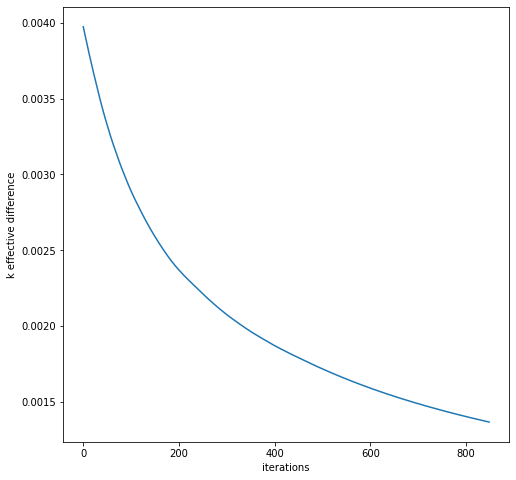

In [214]:
iterations = range(0, len(std_1))
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.xlabel("iterations")
plt.ylabel("k effective difference")

plt.plot(iterations, std_1)

In [435]:
x_5 = Plane(1, 0, 0, 100)
x_m5 = Plane(1, 0, 0, -100)

y_5 = Plane(0, 1, 0, 2.256751)
y_m5 = Plane(0, 1, 0, -2.256751)


z_5 = Plane(0, 0, 1, 100)
z_m5 = Plane(0, 0, 1, -100)

surfaces = [x_5, x_m5, y_5, y_m5, z_5, z_m5]

signs = [-1, +1, -1, +1, -1, +1]
slab_2 = Cell(surfaces, signs)

boundaries_type = [ "reflective", "reflective", "black", "black", "reflective", "reflective"]

slab = Cell(surfaces, signs)

slab.set_boundaries_type(boundaries_type)

slab.set_box_sizes(100., 0., 100.)
slab.set_zero_point(0., 0., 0.)


In [437]:
test_number_of_particles = 20
test_number_interations = 500
test_number_inactive = 10

In [438]:
k_effective1, k_effective_exp1, k_effective_std1 = simulation_black_boundaries(slab,  test_number_interations,  test_number_inactive, 
                           test_number_of_particles, pu_23_cs_1_4)

 num1  6
i == 0
i == 1
i == 2
i == 3
i == 4
i == 5
i == 6
i == 7
i == 8
i == 9
i == 10
i == 11
 keff_cycle , k_effective_exp, std_k_effective 1.0073495400329642   1.0073495400329642  0.0
i == 12
 keff_cycle , k_effective_exp, std_k_effective 1.0137711383202288   1.0105603391765965  3.439966435591468e-05
i == 13
 keff_cycle , k_effective_exp, std_k_effective 0.9885806424741563   1.0032337736091164  0.000118665921542834
i == 14
 keff_cycle , k_effective_exp, std_k_effective 0.9723270414828769   0.9955070905775565  0.0001788129734427039
i == 15
 keff_cycle , k_effective_exp, std_k_effective 0.9794978159913253   0.9923052356603103  0.00016930877926276427
i == 16
 keff_cycle , k_effective_exp, std_k_effective 0.9973879513982493   0.9931523549499669  0.00014940130750211523
i == 17
 keff_cycle , k_effective_exp, std_k_effective 1.0133653105966525   0.9960399200423505  0.00014869824190923652
i == 18
 keff_cycle , k_effective_exp, std_k_effective 0.9968149945953245   0.9961368043614723  0.00013

 keff_cycle , k_effective_exp, std_k_effective 0.9987224258660692   0.9989052308944119  2.1613420403898947e-05
i == 81
 keff_cycle , k_effective_exp, std_k_effective 1.0030031894901752   0.9989629486211127  2.1089106161610916e-05
i == 82
 keff_cycle , k_effective_exp, std_k_effective 0.9807990431321157   0.9987106721559876  2.075318216241535e-05
i == 83
 keff_cycle , k_effective_exp, std_k_effective 1.0182320589653504   0.9989780884136502  2.0452445022128357e-05
i == 84
 keff_cycle , k_effective_exp, std_k_effective 1.00305070078469   0.9990331237159614  1.9973909978640817e-05
i == 85
 keff_cycle , k_effective_exp, std_k_effective 1.0016777907395291   0.9990683859429424  1.9507405591656535e-05
i == 86
 keff_cycle , k_effective_exp, std_k_effective 0.9899587248067716   0.9989485219806243  1.909391939734544e-05
i == 87
 keff_cycle , k_effective_exp, std_k_effective 1.0217517793499753   0.9992446681802263  1.8899110326111873e-05
i == 88
 keff_cycle , k_effective_exp, std_k_effective 0.995

 keff_cycle , k_effective_exp, std_k_effective 0.9803459997382865   1.0003225244424898  8.825453891864768e-06
i == 150
 keff_cycle , k_effective_exp, std_k_effective 0.9818837102308899   1.0001908186266928  8.746497645437918e-06
i == 151
 keff_cycle , k_effective_exp, std_k_effective 0.9975688142097277   1.000172222850686  8.631420802933324e-06
i == 152
 keff_cycle , k_effective_exp, std_k_effective 1.0030207624556542   1.000192282988749  8.518747218239401e-06
i == 153
 keff_cycle , k_effective_exp, std_k_effective 1.0091782992654592   1.0002551222634115  8.416203520037774e-06
i == 154
 keff_cycle , k_effective_exp, std_k_effective 0.9999256074629402   1.0002528339661858  8.306913866030464e-06
i == 155
 keff_cycle , k_effective_exp, std_k_effective 0.968497455690848   1.0000338313573904  8.306211788153438e-06
i == 156
 keff_cycle , k_effective_exp, std_k_effective 0.9968005308582438   1.0000116854635608  8.20080466514335e-06
i == 157
 keff_cycle , k_effective_exp, std_k_effective 1.007

 keff_cycle , k_effective_exp, std_k_effective 1.0004348473573903   1.0001417594725035  4.916381767438728e-06
i == 219
 keff_cycle , k_effective_exp, std_k_effective 0.9917002335736373   1.0001013693964322  4.874675754893378e-06
i == 220
 keff_cycle , k_effective_exp, std_k_effective 1.0064731692586177   1.000131711300538  4.832161991170623e-06
i == 221
 keff_cycle , k_effective_exp, std_k_effective 0.9922875148953143   1.0000945350142572  4.791136337328354e-06
i == 222
 keff_cycle , k_effective_exp, std_k_effective 1.0068509940164578   1.00012640510389  4.749960255350568e-06
i == 223
 keff_cycle , k_effective_exp, std_k_effective 1.0007700829616542   1.0001294270656638  4.7073775867940415e-06
i == 224
 keff_cycle , k_effective_exp, std_k_effective 1.006487630070542   1.0001591382946584  4.6670753927741376e-06
i == 225
 keff_cycle , k_effective_exp, std_k_effective 1.0059595559864274   1.0001861169815969  4.627015126825208e-06
i == 226
 keff_cycle , k_effective_exp, std_k_effective 1.0

 keff_cycle , k_effective_exp, std_k_effective 0.9913105554272875   1.0005008328499039  3.101099747631574e-06
i == 288
 keff_cycle , k_effective_exp, std_k_effective 0.9987462063693403   1.0004945212438587  3.0796372333247046e-06
i == 289
 keff_cycle , k_effective_exp, std_k_effective 0.9897922154627266   1.00045616172493  3.061017081046641e-06
i == 290
 keff_cycle , k_effective_exp, std_k_effective 0.988886878123271   1.000414842854924  3.0430280532532835e-06
i == 291
 keff_cycle , k_effective_exp, std_k_effective 0.9937115024593015   1.0003909875510248  3.0231537792870292e-06
i == 292
 keff_cycle , k_effective_exp, std_k_effective 0.9843501409880527   1.0003341051164043  3.0083550719938395e-06
i == 293
 keff_cycle , k_effective_exp, std_k_effective 0.9944785600566204   1.0003134141444616  2.988601232519593e-06
i == 294
 keff_cycle , k_effective_exp, std_k_effective 1.000388404241088   1.0003136781940978  2.9682707390976505e-06
i == 295
 keff_cycle , k_effective_exp, std_k_effective 0

 keff_cycle , k_effective_exp, std_k_effective 1.0059427734473134   1.0000534627090856  2.2588783534416034e-06
i == 357
 keff_cycle , k_effective_exp, std_k_effective 1.0112855733471369   1.0000858319040078  2.2479565085376767e-06
i == 358
 keff_cycle , k_effective_exp, std_k_effective 1.0390293057772704   1.0001977384381264  2.2560107756391023e-06
i == 359
 keff_cycle , k_effective_exp, std_k_effective 0.9906968090520997   1.0001705151447569  2.244656610045995e-06
i == 360
 keff_cycle , k_effective_exp, std_k_effective 0.961676297906214   1.0000605316669322  2.2519141175329106e-06
i == 361
 keff_cycle , k_effective_exp, std_k_effective 0.9961154405802646   1.0000492920911868  2.239643286734154e-06
i == 362
 keff_cycle , k_effective_exp, std_k_effective 1.011759623063467   1.0000825600769034  2.229066340395802e-06
i == 363
 keff_cycle , k_effective_exp, std_k_effective 0.9703651285571799   0.9999983747184907  2.2282581715834845e-06
i == 364
 keff_cycle , k_effective_exp, std_k_effectiv

 keff_cycle , k_effective_exp, std_k_effective 0.9915542901270772   1.000027001387651  1.7554979498971682e-06
i == 426
 keff_cycle , k_effective_exp, std_k_effective 0.9760299409318376   0.9999693161461708  1.7522641864857927e-06
i == 427
 keff_cycle , k_effective_exp, std_k_effective 1.0093440149225523   0.9999917974382004  1.7448163321199638e-06
i == 428
 keff_cycle , k_effective_exp, std_k_effective 0.9877888041007952   0.9999626036742353  1.737943084072051e-06
i == 429
 keff_cycle , k_effective_exp, std_k_effective 1.0011444136436656   0.9999654242230883  1.7298527311824402e-06
i == 430
 keff_cycle , k_effective_exp, std_k_effective 0.9672433150573455   0.9998875144393605  1.7308984203886617e-06
i == 431
 keff_cycle , k_effective_exp, std_k_effective 0.9909518944696303   0.9998662896888385  1.723539321848566e-06
i == 432
 keff_cycle , k_effective_exp, std_k_effective 1.0146854813466986   0.9999014062567482  1.7174008629374618e-06
i == 433
 keff_cycle , k_effective_exp, std_k_effect

 keff_cycle , k_effective_exp, std_k_effective 0.9945927925507579   1.0002555557552748  1.4093198132556457e-06
i == 495
 keff_cycle , k_effective_exp, std_k_effective 1.0048656307683768   1.0002650610645802  1.403751935750126e-06
i == 496
 keff_cycle , k_effective_exp, std_k_effective 1.002518996518677   1.000269698791852  1.3981217233684322e-06
i == 497
 keff_cycle , k_effective_exp, std_k_effective 0.9780894342370083   1.0002241541007744  1.395393417472447e-06
i == 498
 keff_cycle , k_effective_exp, std_k_effective 1.010789131267822   1.0002458036441495  1.3904434517556224e-06
i == 499
 keff_cycle , k_effective_exp, std_k_effective 0.9626971141688059   1.000169016958106  1.3930724878307984e-06


In [440]:
difference = (k_effective_exp1[-1] - 1.0) * 100000

std_1 = compute_std(k_effective_exp1)
standart_deviation = std_1[-1] * 100000

print(" difference from beachmark [pcm]  " + str(difference) + "  with standart deviation [pcm]+- " + str(standart_deviation))


 difference from beachmark [pcm]  16.901695810589423  with standart deviation [pcm]+- 136.7291524703367
